In [2]:
%config Completer.use_jedi = False

In [3]:

import csv
import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from statistics import mean
        
from sklearn import svm as SKsvm

In [4]:
class Dataset:
    def __init__(self, dataset_name, dataset_path, coloumn_names, 
                 sep=None, output_column_name='class', 
                 test_size=0.2, normalization_method='zero_mean_unit_var'):
        """
        self.x_train                 ->     vector-x0 + data_x_train_normalized
        self.x_test                  ->     vector-x0 + data_x_test_normalized
        
        self.y_train                 ->     y_train
        self.y_test                  ->     y_test
        """
        
        self.normalization_method = normalization_method
        self.dataset_link = dataset_path
        self.sep = sep
        self.coloumn_names = coloumn_names
        RANDOM_STATE = 1
        
        if dataset_name == "health":
            # read data using pandas
            self.data_frame = pd.read_csv(self.dataset_link, self.sep, names=self.coloumn_names)

            # export y_train & y_test and convert to numpy array
            self.y = self.data_frame[output_column_name].to_numpy()
            # remove y from x_train & x_test
            self.x = self.data_frame.drop([output_column_name], axis=1).to_numpy()

            # normalize data
            self.x = self.normalize(normalization_method)
            
            # split test & train
            # rename label=2 to label=0 for working
            self.y[self.y == 2] = 0
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=RANDOM_STATE)
        
        elif dataset_name == "dataset":
            data = scipy.io.loadmat(self.dataset_link)
            self.x, self.y = data['X'], data['y']
            
            # reshape labels
            self.y = self.y.reshape(-1)
            
            # normalize data
            self.x = self.normalize(normalization_method)
            
            # split test & train
            # rename label=2 to label=0 for working
            self.y[self.y == 2] = 0
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size)
        
            
        
    """
    Normalizing data improves the convergence of learning model and causes that smaller features also be able to affect the model parameters.
    """
    def normalize(self, normalization_method):
        if normalization_method == 'none':
            print("No normalization.")
            t = self.x

        if normalization_method == 'zero_mean_unit_var':
            print("zero-mean & unit_variance normalization.")
            t = self.zero_mean_unit_variance(self.x)            
            
        if normalization_method == 'scale_0_1':
            print("scaling to [0, 1] normalization.")
            t = self.scaling_between_0_1(self.x)
        return t
     
    
    def scaling_between_0_1(self, numpy_array):
        '''
        Scaling
        '''
        normed_numpy_array = (numpy_array - numpy_array.min()) / (numpy_array.max() - numpy_array.min())
        return normed_numpy_array


    def zero_mean_unit_variance(self, numpy_array):
        '''
        Standardization
        '''
        normed_numpy_array = (numpy_array - numpy_array.mean()) / numpy_array.std()
        return normed_numpy_array

In [5]:

coloumn_names = [str(i) for i in range(13)] + ['class']
health = Dataset(dataset_name="health", dataset_path='Health.dat', 
                  coloumn_names=coloumn_names, 
                  sep=' ', 
                  output_column_name='class', normalization_method='none')
print("health: ", health.x_train.shape, health.x_test.shape)


No normalization.
health:  (216, 13) (54, 13)


In [6]:

coloumn_names = [str(i) for i in range(2)] + ['class']
dataset1 = Dataset(dataset_name="dataset", dataset_path="Dataset1.mat", 
                    coloumn_names=coloumn_names, 
                    output_column_name='class', normalization_method='none')

print("dataset1: ", dataset1.x_train.shape, dataset1.x_test.shape)


No normalization.
dataset1:  (40, 2) (11, 2)


In [7]:

coloumn_names = [str(i) for i in range(2)] + ['class']
dataset2 = Dataset(dataset_name="dataset", dataset_path="Dataset2.mat", 
                    coloumn_names=coloumn_names, 
                    output_column_name='class', normalization_method='none')

print("dataset2: ", dataset2.x_train.shape, dataset2.x_test.shape)


No normalization.
dataset2:  (328, 2) (83, 2)


In [8]:
# class_labels = np.unique(y)
# class_labels

In [9]:
def plot_data(x, y, title="plot"):
    y_list = []
    for i in range(len(y)):
        y_list.append(y[i])
    df = pd.DataFrame(dict(x=x[:, 0], y=x[:, 1], label=y_list))
    colors = {0: 'orange', 1: 'green', 2: 'blue', 3: 'brown'}
    fig1, ax = plt.subplots()
    groups = df.groupby('label')
    for key, group in groups:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], title=title)
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.show()

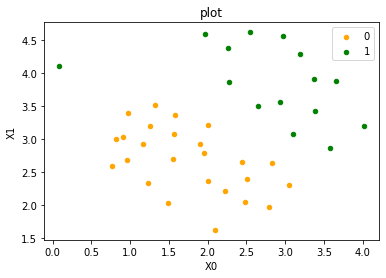

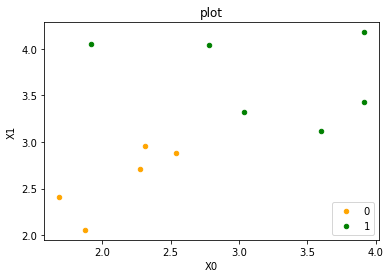

In [10]:
plot_data(dataset1.x_train, dataset1.y_train)

plot_data(dataset1.x_test, dataset1.y_test)

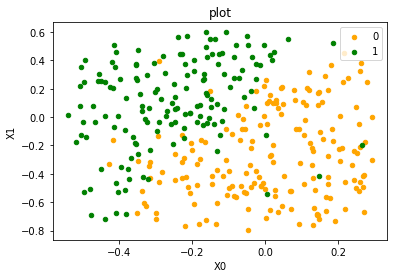

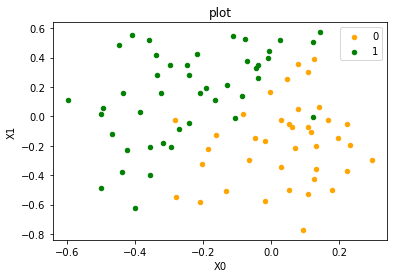

In [11]:
plot_data(dataset2.x_train, dataset2.y_train)

plot_data(dataset2.x_test, dataset2.y_test)

In [12]:
class SVM():
    def __init__(self, x_train, x_test, y_train, y_test, dataset_name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        self.dataset_name = dataset_name

    def accuracy(self, y, y_pred):
        res = 0
        for i in range(0, len(y)):
            if y_pred[i] == y[i]:
                res += 1
        return (res / float(len(y))) * 100

    def svm(self, kernel='linear', C=1, gamma='scale'):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        
        self.labels = np.unique(self.y_train)
        
        train_predict = []
        test_predict = []
        
        #Create a svm Classifier
        self.model = SKsvm.SVC(kernel=self.kernel ,C = self.C, gamma=self.gamma) 

        #Train the model using the training sets
        self.model.fit(self.x_train, self.y_train)

        #Predict for test dataset
        self.predicted_y_train = self.model.predict(self.x_train)
        
        #Predict for test dataset
        self.predicted_y_test = self.model.predict(self.x_test)
        
        # find accuracies
        self.train_accuracy = self.accuracy(self.y_train, self.predicted_y_train)
        self.test_accuracy = self.accuracy(self.y_test, self.predicted_y_test)
        
    def plot_data_(self, x, y, title="plot"):
        y_list = []
        for i in range(len(y)):
            y_list.append(y[i])
        df = pd.DataFrame(dict(x=x[:, 0], y=x[:, 1], label=y_list))
        colors = {0: 'orange', 1: 'green', 2: 'blue', 3: 'brown'}
        fig1, ax = plt.subplots()
        groups = df.groupby('label')
        for key, group in groups:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], title=title)
        
        if self.kernel=='linear':
            '''
            y = mx + c
            c = -b/w2
            m = -w1/w2

            here:
            b->intercept
            w1->w[0]
            w2->w[1]
            '''
            xlim = ax.get_xlim()
            w = self.model.coef_[0]
            a = -w[0] / w[1]
            xx = np.linspace(xlim[0], xlim[1])

            yy = a * xx - self.model.intercept_[0] / w[1]
            plt.plot(xx, yy)

            yy = a * xx - (self.model.intercept_[0] - 1) / w[1]
            plt.plot(xx, yy, 'k--')
            yy = a * xx - (self.model.intercept_[0] + 1) / w[1]
            plt.plot(xx, yy, 'k--')
            
        elif self.kernel=='rbf':
            x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
            y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
            h = .02  # step size in the mesh
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            
            Z = self.model.predict(np.c_[xx.ravel(), yy.ravel()])

            Z = Z.reshape(xx.shape)
            #PuOr
            plt.contourf(xx, yy, Z, cmap=plt.cm.PiYG, alpha = 0.3)

#             plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.xticks(())
            plt.yticks(())
        
        plt.xlabel('X0')
        plt.ylabel('X1')
        plt.show()
    
    def plot(self):
        self.plot_data_(self.x_train, self.y_train, f'{self.dataset_name} | Train Data | kernel={self.kernel} | C={self.C} | {"" if svm.kernel=="linear" else "gamma="+str(svm.gamma)+" | "} Accuracy={self.train_accuracy}')
        self.plot_data_(self.x_test, self.y_test, f'{self.dataset_name} | Test Data | kernel={self.kernel} | C={self.C} | {"" if svm.kernel=="linear" else "gamma="+str(svm.gamma)+" | "} Accuracy={self.test_accuracy}')

    def report(self):
        train = f'{self.dataset_name} | Train Data | kernel={self.kernel} | C={self.C} | {"" if svm.kernel=="linear" else "gamma="+str(svm.gamma)+" | "} Accuracy={self.train_accuracy}'
        test = f'{self.dataset_name} | Test Data | kernel={self.kernel} | C={self.C} | {"" if svm.kernel=="linear" else "gamma="+str(svm.gamma)+" | "} Accuracy={self.test_accuracy}'
        print(train)
        print(test)
        

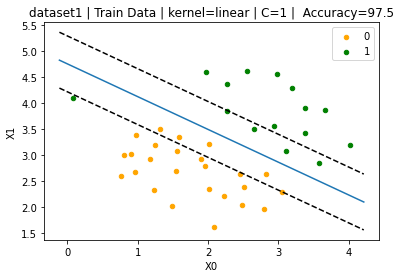

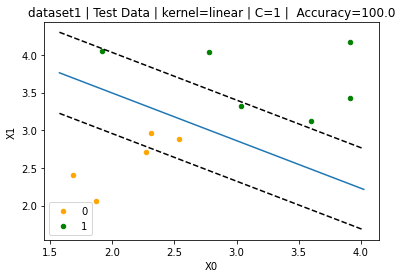

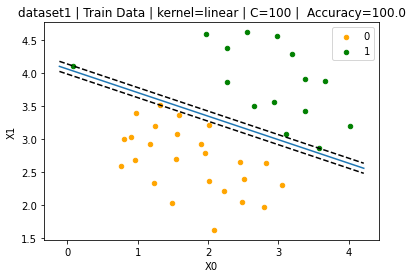

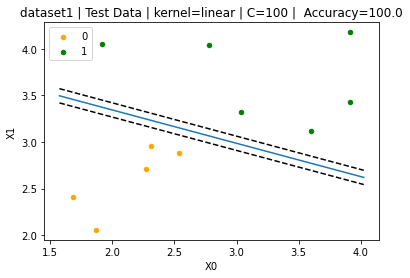

In [13]:
svm = SVM(dataset1.x_train, dataset1.x_test, dataset1.y_train, dataset1.y_test, dataset_name='dataset1')
svm.svm(kernel='linear', C=1)
svm.plot()

svm.svm(kernel='linear', C=100)
svm.plot()

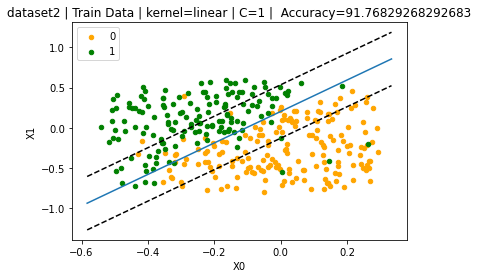

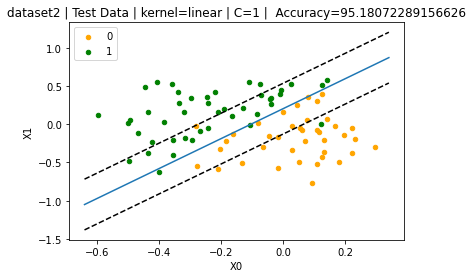

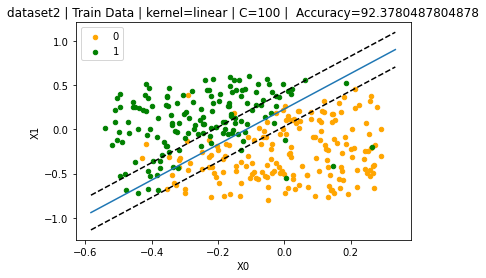

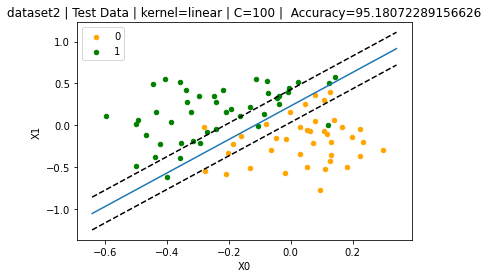

In [14]:
svm = SVM(dataset2.x_train, dataset2.x_test, dataset2.y_train, dataset2.y_test, dataset_name='dataset2')
svm.svm(kernel='linear', C=1)
svm.plot()

svm.svm(kernel='linear', C=100)
svm.plot()

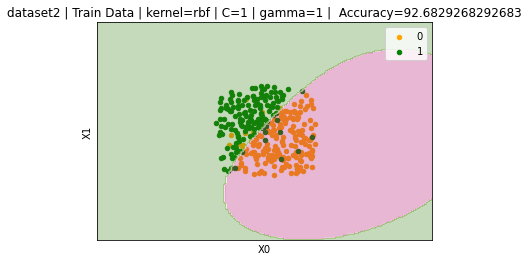

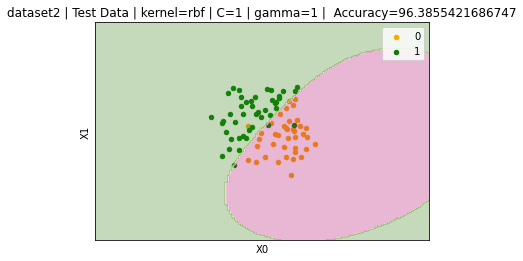

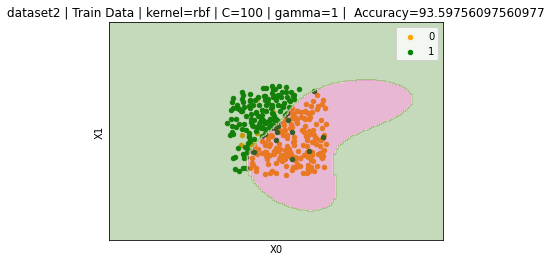

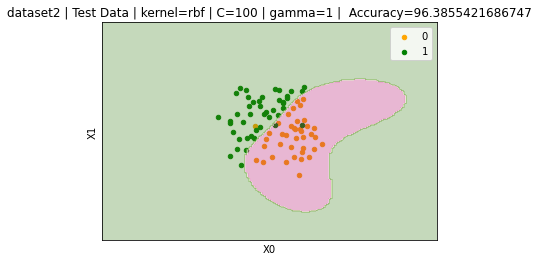

In [15]:
svm = SVM(dataset2.x_train, dataset2.x_test, dataset2.y_train, dataset2.y_test, dataset_name='dataset2')
svm.svm(kernel='rbf', C=1, gamma=1)
svm.plot()

svm.svm(kernel='rbf', C=100, gamma=1)
svm.plot()

In [31]:
svm = SVM(health.x_train, health.x_test, health.y_train, health.y_test, dataset_name='health')
svm.svm(kernel='rbf', C=1)
svm.report()

svm.svm(kernel='rbf', C=100)
svm.report()

health | Train Data | kernel=rbf | C=1 | gamma=scale |  Accuracy=66.66666666666666
health | Test Data | kernel=rbf | C=1 | gamma=scale |  Accuracy=68.51851851851852
health | Train Data | kernel=rbf | C=100 | gamma=scale |  Accuracy=81.94444444444444
health | Test Data | kernel=rbf | C=100 | gamma=scale |  Accuracy=83.33333333333334


In [17]:
from sklearn.model_selection import cross_val_score

def find_C_gamma(dataset, dataset_name, kernel, Cs_array, Gamma_array=[], split=5):
    
    best_acc = 0
    best_C = None
    best_gamma = None
    
    list_all_mean_C = []
    list_all_std_C = []
    
    
    list_all_mean_C_with_gamma = []
    list_all_std_C_with_gamma = []
    
    for C in Cs_array:
        if len(Gamma_array) != 0:
            list_C_mtmp = []
            list_C_stmp = []
            for gamma in Gamma_array:
                model = SKsvm.SVC(kernel=kernel ,C = C, gamma=gamma) 
                list_acc = cross_val_score(model, dataset.x, dataset.y, cv=split)
                
                mean_all = list_acc.mean()
                std_all = list_acc.std()
                
                list_C_mtmp.append(mean_all)
                list_C_stmp.append(std_all)
                
                print(f'{split} time {split} fold: all accuracy for C = ', C, 'and gamma = ',gamma, ' is ', mean_all, ' in ', dataset_name)
                print(30*'-')
                if mean_all > best_acc:
                    best_C = C
                    best_gamma = gamma
                    best_acc = mean_all
                    
            list_all_mean_C_with_gamma.append(list_C_mtmp)
            list_all_std_C_with_gamma.append(list_C_stmp)
            
        else:
            model = SKsvm.SVC(kernel=kernel ,C = C) 
            list_acc = cross_val_score(model, dataset.x, dataset.y, cv=split)            
            
            mean_all = list_acc.mean()
            std_all = list_acc.std()
            
            list_all_mean_C.append(mean_all)
            list_all_std_C.append(std_all)
            
            print(f'{split} time {split} fold: all accuracy for C = ', C, ' is ', mean_all, ' in ', dataset_name)
            print(30*'-')
            if mean_all > best_acc:
                best_C = C
                best_acc = mean_all
        
    if len(Gamma_array) != 0:
        plot_acc_mean_std(True, list_all_mean_C_with_gamma, list_all_std_C_with_gamma, Cs_array, Gamma_array)
    else:
        plot_acc_mean_std(False, list_all_mean_C, list_all_std_C, Cs_array)
        
    return best_C, best_acc, best_gamma

In [18]:
def plot_acc_mean_std(flag, means, stds, Cs_array, Gamma_array=[]):
    if flag == False:        
        y1 = [means[i]+stds[i] for i in range(len(means))]
        y2 = [means[i]-stds[i] for i in range(len(means))]
        fig, ax = plt.subplots()

        ax.fill_between(Cs_array, y1, y2, alpha=.5, linewidth=0, label='-+std')
        ax.plot(Cs_array, means, 'o-', linewidth=2, label='mean accuracy')
        ax.plot(Cs_array, [means[i]+stds[i] for i in range(len(means))], 'g^', label='mean + std')
        ax.plot(Cs_array, [means[i]-stds[i] for i in range(len(means))], 'gv', label='mean - std')
        plt.legend()
        plt.show()
        
    elif flag == True:
        # 3D
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for m in ['o', '^', 'v']:
            for i in range(len(Cs_array)):
                xs = len(Cs_array)*[Cs_array[i]]
                ys = Gamma_array
                if m == 'o':
                    zs = means[i]
                    color = 'b'
                elif m == '^':
                    zs = [means[i][j]+stds[i][j] for j in range(len(means[i]))]
                    color = 'g'
                elif m == 'v':
                    zs = [means[i][j]-stds[i][j] for j in range(len(means[i]))]
                    color = 'g'
                ax.scatter(xs, ys, zs, marker=m, color=color)
        plt.show()

10 time 10 fold: all accuracy for C =  0.01  is  0.7712543554006969  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.04  is  0.8879790940766551  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.1  is  0.9148083623693382  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.4  is  0.9343205574912892  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  1  is  0.941637630662021  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  4  is  0.9440766550522648  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  10  is  0.9489547038327526  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  40  is  0.9368176538908246  in  Dataset2
------------------------------


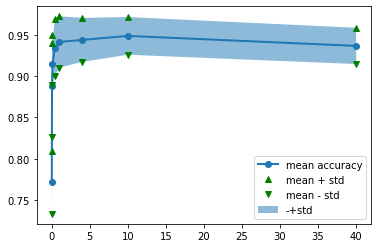

best C:  10
best accuracy:  0.9489547038327526


In [19]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, best_acc, _ = find_C_gamma(dataset2, 'Dataset2', kernel='rbf', Cs_array=Cs_array, split=10)
print("best C: ", best_C)
print("best accuracy: ", best_acc)


10 time 10 fold: all accuracy for C =  0.01  is  0.5555555555555556  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  0.04  is  0.5555555555555556  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  0.1  is  0.5555555555555556  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  0.4  is  0.6370370370370371  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  1  is  0.6518518518518518  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  4  is  0.6814814814814815  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  10  is  0.7037037037037037  in  Health
------------------------------
10 time 10 fold: all accuracy for C =  40  is  0.7444444444444444  in  Health
------------------------------


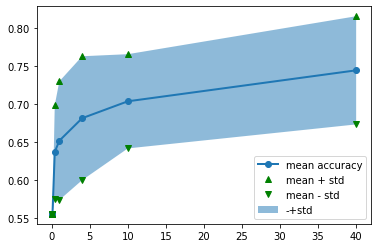

best C:  40
best accuracy:  0.7444444444444444


In [20]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, best_acc, _ = find_C_gamma(health, 'Health', kernel='rbf', Cs_array=Cs_array, split=10)
print("best C: ", best_C)
print("best accuracy: ", best_acc)

5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.01  is  0.5304143402879812  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.04  is  0.5304143402879812  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.1  is  0.5304143402879812  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.4  is  0.5304143402879812  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  1  is  0.5304143402879812  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  4  is  0.7081398765794885  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  10  is  0.5426094622392007  in  Dataset2
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  40  is  0.5304143402879812  in  Dataset2
-----------

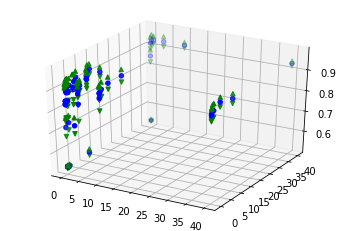

best C:  1  & best gamma:  10
best accuracy:  0.9489861886570672


In [32]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
# gamma = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
gamma = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, best_acc, best_gamma = find_C_gamma(dataset2, 'Dataset2', kernel='rbf', 
                                            Cs_array=Cs_array, Gamma_array=gamma, split=5)
print("best C: ", best_C, ' & best gamma: ', best_gamma)
print("best accuracy: ", best_acc)

10 time 10 fold: all accuracy for C =  0.01 and gamma =  0.01  is  0.5304297328687573  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  0.04  is  0.5304297328687573  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  0.1  is  0.5304297328687573  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  0.4  is  0.5304297328687573  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  1  is  0.5304297328687573  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  4  is  0.7907084785133566  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  10  is  0.6204413472706156  in  Dataset2
------------------------------
10 time 10 fold: all accuracy for C =  0.01 and gamma =  40  is  0.5304297328687573  in  Data

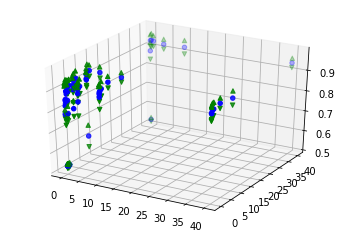

best C:  10  & best gamma:  4
best accuracy:  0.9489547038327526


In [21]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
# gamma = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
gamma = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, best_acc, best_gamma = find_C_gamma(dataset2, 'Dataset2', kernel='rbf', 
                                            Cs_array=Cs_array, Gamma_array=gamma, split=10)
print("best C: ", best_C, ' & best gamma: ', best_gamma)
print("best accuracy: ", best_acc)

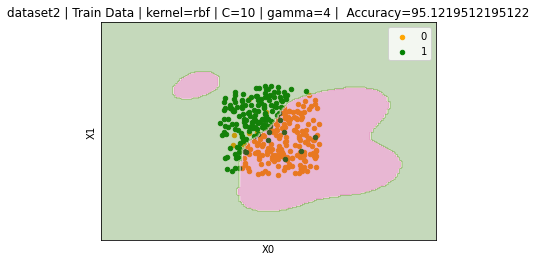

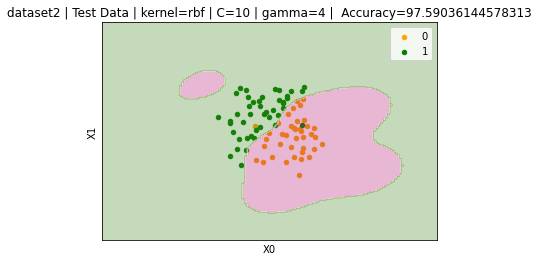

In [22]:
svm = SVM(dataset2.x_train, dataset2.x_test, dataset2.y_train, dataset2.y_test, dataset_name='dataset2')
svm.svm(kernel='rbf', C=best_C, gamma=best_gamma)
svm.plot()

5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.01  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.04  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.1  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  0.4  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  1  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  4  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  10  is  0.5555555555555556  in  Health
------------------------------
5 time 5 fold: all accuracy for C =  0.01 and gamma =  40  is  0.5555555555555556  in  Health
---------------------------

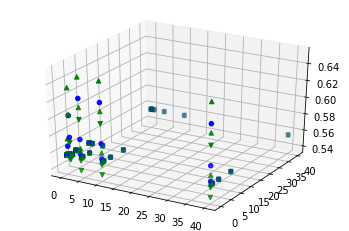

best C:  4  & best gamma:  0.01
best accuracy:  0.625925925925926


In [23]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
# gamma = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
gamma = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]

best_C, best_acc, best_gamma = find_C_gamma(health, 'Health', kernel='rbf',
                                            Cs_array=Cs_array, Gamma_array=gamma, split=5)
print("best C: ", best_C, ' & best gamma: ', best_gamma)
print("best accuracy: ", best_acc)

In [24]:
svm = SVM(health.x_train, health.x_test, health.y_train, health.y_test, dataset_name='health')
svm.svm(kernel='rbf', C=best_C, gamma=best_gamma) 
svm.report()

health | Train Data | kernel=rbf | C=4 | gamma=0.01 |  Accuracy=100.0
health | Test Data | kernel=rbf | C=4 | gamma=0.01 |  Accuracy=62.96296296296296


In [25]:
def find_best_kFold(dataset, dataset_name, Cs_array, kernel, split=5):
    kfold =  KFold(n_splits=split)

    train_best_acc = 0
    test_best_acc = 0
    best_C = None
    
    train_acc = []
    test_acc = []
    
    for C in Cs_array:
        for train_index, test_index in kfold.split(dataset.x):
            x_train, x_test = dataset.x[train_index], dataset.x[test_index]
            y_train, y_test = dataset.y[train_index], dataset.y[test_index]
            
            svm = SVM(x_train, x_test, y_train, y_test, dataset_name)
            svm.svm(kernel=kernel, C=C)
            
            train_acc.append(svm.train_accuracy)
            test_acc.append(svm.test_accuracy)
            
        mean_train_acc = mean(train_acc)
        mean_test_acc = mean(test_acc)
        print(f'{split} time {split} fold: train accuracy for C = ', C, ' is ', mean_train_acc, ' in ', dataset_name)
        print(f'{split} time {split} fold: test  accuracy for C = ', C, ' is ', mean_test_acc, ' in ', dataset_name)
        print(30*'-')
        if mean_train_acc > train_best_acc and mean_test_acc > test_best_acc:
            best_C = C
            train_best_acc = mean_train_acc
            test_best_acc = mean_test_acc
        
    return best_C, train_best_acc, test_best_acc

In [26]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, train_best_acc, test_best_acc = find_best_kFold(dataset2, 'Dataset2', Cs_array, kernel='rbf', split=10)
print("best C: ", best_C)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

10 time 10 fold: train accuracy for C =  0.01  is  76.1817915476452  in  Dataset2
10 time 10 fold: test  accuracy for C =  0.01  is  69.58188153310105  in  Dataset2
------------------------------
10 time 10 fold: train accuracy for C =  0.04  is  83.40057130301032  in  Dataset2
10 time 10 fold: test  accuracy for C =  0.04  is  79.19570267131243  in  Dataset2
------------------------------
10 time 10 fold: train accuracy for C =  0.1  is  86.32046680827169  in  Dataset2
10 time 10 fold: test  accuracy for C =  0.1  is  83.05071622144793  in  Dataset2
------------------------------
10 time 10 fold: train accuracy for C =  0.4  is  88.34139017065847  in  Dataset2
10 time 10 fold: test  accuracy for C =  0.4  is  85.64895470383276  in  Dataset2
------------------------------
10 time 10 fold: train accuracy for C =  1  is  89.58095656632241  in  Dataset2
10 time 10 fold: test  accuracy for C =  1  is  87.25783972125436  in  Dataset2
------------------------------
10 time 10 fold: train acc

In [27]:
Cs_array = [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40]
best_C, train_best_acc, test_best_acc = find_best_kFold(health, 'Health', Cs_array, kernel='rbf', split=10)
print("best C: ", best_C)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

10 time 10 fold: train accuracy for C =  0.01  is  55.55555555555556  in  Health
10 time 10 fold: test  accuracy for C =  0.01  is  55.55555555555555  in  Health
------------------------------
10 time 10 fold: train accuracy for C =  0.04  is  55.55555555555556  in  Health
10 time 10 fold: test  accuracy for C =  0.04  is  55.55555555555555  in  Health
------------------------------
10 time 10 fold: train accuracy for C =  0.1  is  55.55555555555556  in  Health
10 time 10 fold: test  accuracy for C =  0.1  is  55.55555555555555  in  Health
------------------------------
10 time 10 fold: train accuracy for C =  0.4  is  57.88065843621399  in  Health
10 time 10 fold: test  accuracy for C =  0.4  is  57.68518518518518  in  Health
------------------------------
10 time 10 fold: train accuracy for C =  1  is  59.63786008230453  in  Health
10 time 10 fold: test  accuracy for C =  1  is  59.33333333333333  in  Health
------------------------------
10 time 10 fold: train accuracy for C =  4  i

### Only test for myself

In [28]:
from sklearn.model_selection import GridSearchCV
#  [0.1, 1, 10, 100, 1000]
param_grid = {'C': [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40],
              'gamma': [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40],
              'kernel': ['rbf']}
 
# svm = SVM(dataset2.x_train, dataset2.x_test, dataset2.y_train, dataset2.y_test, dataset_name='dataset2')
grid = GridSearchCV(SKsvm.SVC(), param_grid, refit = True, verbose = 3)
grid.fit(dataset2.x, dataset2.y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END .................C=0.01, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=0.01, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=0.01, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.01, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.01, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 1/5] END ..................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ..................C=0.01, gamma=0.

[CV 1/5] END .....................C=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV 1/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=10, kernel=rbf; total time=   0.0s
[CV 1/5] END ....................C=0.1, gamma=40, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=40, kernel=rbf; total time=   0.0s
[CV 3/5] END ...............

[CV 3/5] END ....................C=4, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 4/5] END ....................C=4, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 5/5] END ....................C=4, gamma=0.04, kernel=rbf; total time=   0.0s
[CV 1/5] END .....................C=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=4, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END .....................C=4, gamma=0.4, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=4, gamma=0.4, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=4, gamma=0.4, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=4, gamma=0.4, kernel=rbf; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END .....................C=40, gamma=10, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=40, gamma=10, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=40, gamma=10, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=40, gamma=10, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=40, gamma=10, kernel=rbf; total time=   0.0s
[CV 1/5] END .....................C=40, gamma=40, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=40, gamma=40, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=40, gamma=40, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=40, gamma=40, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=40, gamma=40, kernel=rbf; total time=   0.0s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40],
                         'gamma': [0.01, 0.04, 0.1, 0.4, 1, 4, 10, 40],
                         'kernel': ['rbf']},
             verbose=3)

In [29]:
print('5 fold')
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(dataset2.x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(dataset2.y_test, grid_predictions))

5 fold
{'C': 1, 'gamma': 10, 'kernel': 'rbf'}
SVC(C=1, gamma=10)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.98      0.98      0.98        44

    accuracy                           0.98        83
   macro avg       0.98      0.98      0.98        83
weighted avg       0.98      0.98      0.98        83



In [30]:
grid.cv_results_

{'mean_fit_time': array([0.01840587, 0.00836606, 0.01047063, 0.01070514, 0.01224389,
        0.01209416, 0.01313014, 0.01413188, 0.01395178, 0.01481676,
        0.01262054, 0.01361828, 0.01434903, 0.0151072 , 0.00879426,
        0.01722608, 0.01517053, 0.01820216, 0.0155755 , 0.01212015,
        0.01528354, 0.01032057, 0.00626817, 0.01369681, 0.01288042,
        0.01642318, 0.01114712, 0.01092205, 0.00785351, 0.00532961,
        0.01021838, 0.01177096, 0.01153951, 0.01436362, 0.01462049,
        0.00786886, 0.00524368, 0.00375323, 0.00639009, 0.00975223,
        0.00952535, 0.00740061, 0.00796542, 0.00442281, 0.00382352,
        0.00614252, 0.00369339, 0.00835276, 0.00684228, 0.00916176,
        0.0092248 , 0.00444641, 0.00572042, 0.00798807, 0.00640163,
        0.00716887, 0.00544882, 0.00341487, 0.00687656, 0.0064662 ,
        0.01143227, 0.00697503, 0.0103869 , 0.01096406]),
 'std_fit_time': array([0.00372335, 0.00239817, 0.00336778, 0.00437966, 0.00332985,
        0.00324647, 0.001